# Task 1

## Data preparation

In [158]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GroupShuffleSplit, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

In [135]:
df = pd.read_csv('../../data/answerList_data.csv')
df['correctness'] = (((df['GroundTruth'] == 0.0) & (df['Answer.option'] == 'NO')) | (
            (df['GroundTruth'] == 1.0) & (df['Answer.option'] == 'YES'))).astype(int)

df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#,1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1


In [136]:
# We balance the dataset by taking the same number of samples for each class

df_0 = df[df['GroundTruth'] == 0]
df_1 = df[df['GroundTruth'] == 1]

if len(df_0) > len(df_1):
    df_0_balanced = df_0.sample(len(df_1))
    df_balanced = pd.concat([df_0_balanced, df_1])
else:
    df_1_balanced = df_1.sample(len(df_0))
    df_balanced = pd.concat([df_0, df_1_balanced])

df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

df = df_balanced
df.groupby('GroundTruth').size()

GroundTruth
0    500
1    500
dtype: int64

In [137]:
def calculate_ttr(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens) if tokens else 0
    return ttr


df['TTR'] = df['Answer.explanation'].astype(str).apply(calculate_ttr)
df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR
0,871,HIT04_7,63,146.780,5,3,0,0,1,0,...,4,Professional_Developer,5.0,30,Male,University,United States,C#,1,0.785714
1,1158,HIT04_7,68,578.773,4,5,0,0,0,0,...,4,Professional_Developer,6.0,29,Female,University;Web,USA,JAVA,0,1.000000
2,1948,HIT06_51,96,169.926,4,3,0,0,1,0,...,5,Graduate_Student,10.0,25,Male,High School;University;Web,US,C++,1,1.000000
3,1926,HIT08_54,125,1621.791,5,2,0,0,0,0,...,5,Professional_Developer,32.0,48,Male,High School;University;Web,United States,C++; PHP; JavaScript; HTML,0,0.570248
4,47,HIT02_24,11,336.265,2,3,0,0,0,0,...,3,Professional_Developer,5.0,30,Female,University,USA,Java; C,0,0.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,454,HIT01_8,1,47.276,4,4,1,0,0,1,...,5,Professional_Developer,16.0,40,Female,University,India,XML; PHP; Java,0,1.000000
996,2166,HIT08_54,127,219.831,4,3,0,0,0,0,...,5,Professional_Developer,5.0,32,Male,University,USA,SQL,0,0.767442
997,927,HIT04_7,51,117.974,5,2,0,0,1,0,...,4,Professional_Developer,17.0,32,Male,High School;University;Web;Other Books,USA,Javascript,1,1.000000
998,472,HIT03_6,24,504.882,4,4,0,0,0,0,...,3,Hobbyist,35.0,59,Male,University;Web;Other self study,USA,Euphoria,0,0.756098


In [138]:
df['explanation_size'] = df['Answer.explanation'].astype(str).apply(len)

In [139]:
df
df['Answer.option.int'] = df['Answer.option'].map({'NO': 0, 'IDK': 0.5, 'YES': 1})
df['Worker.gender.int'] = df['Worker.gender'].map({'Male': -1, 'Other': 0, 'Female': 1})
df['Worker.profession.int'] = df['Worker.profession'].map(
    {'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer': 4})


In [140]:
df_holdout = df[df['FailingMethod'].isin(['HIT03_06', 'HIT04_7'])]
df_train = df[~df['FailingMethod'].isin(['HIT03_06', 'HIT04_7'])]

In [141]:
df_train_students = df_train[df_train['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_train_non_students = df_train[~df_train['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_holdout_students = df_holdout[df_holdout['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_holdout_non_students = df_holdout[
    ~df_holdout['Worker.profession'].isin(['Undergraduate_Student', 'Graduate_Student'])]
df_holdout_non_students

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,explanation_size,Answer.option.int,Worker.gender.int,Worker.profession.int
0,871,HIT04_7,63,146.780,5,3,0,0,1,0,...,Male,University,United States,C#,1,0.785714,73,0.0,-1,4
1,1158,HIT04_7,68,578.773,4,5,0,0,0,0,...,Female,University;Web,USA,JAVA,0,1.000000,14,1.0,1,4
14,691,HIT04_7,46,137.110,4,4,0,0,0,0,...,Female,High School;University;Web,USA,java,0,1.000000,46,1.0,1,4
25,1212,HIT04_7,56,55.848,0,5,1,0,0,1,...,Male,High School;University;Web;Other books,Russia,C++;Object Pascal,0,1.000000,8,0.5,-1,4
27,1180,HIT04_7,40,69.812,4,4,0,0,0,0,...,Male,University,india,java,0,1.000000,45,1.0,-1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,991,HIT04_7,38,62.117,2,4,0,0,0,0,...,Female,University,India,VisualBasic,0,1.000000,26,1.0,1,0
980,687,HIT04_7,46,107.580,5,3,0,0,1,0,...,Male,High School;University;Other as long as i can ...,USA,c++,1,1.000000,39,0.0,-1,4
986,937,HIT04_7,51,61.868,5,2,0,0,1,0,...,Male,High School;University;Web,United States,Java,1,0.928571,88,0.0,-1,4
997,927,HIT04_7,51,117.974,5,2,0,0,1,0,...,Male,High School;University;Web;Other Books,USA,Javascript,1,1.000000,59,0.0,-1,4


In [142]:
input_cols = ['Worker.score', 'Worker.profession.int', 'Answer.duration', 'TTR', 'explanation_size', 'Answer.confidence',
              'Answer.difficulty'] # only use these input columns, because specified in the task
output_col = 'correctness'

X = df_train_students[input_cols]
y = df_train_students[output_col]

groups = df_train_students['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1 / len(pd.unique(groups)))

In [143]:
def get_decision_tree_classifier(min_samples_leaf, max_depth, return_model=True, print_metrics=True):
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth)

    cv_results = cross_validate(
        clf, X, y, cv=gss, groups=groups,
        scoring=['precision', 'recall', 'f1'],
        return_estimator=True,
        return_train_score=True
    )
    if print_metrics:
        print("Mean Precision train:", np.mean(cv_results['train_precision']))
        print("Mean Recall train:", np.mean(cv_results['train_recall']))

        print("Precision for each fold:", cv_results['test_precision'])
        print("Mean Precision:", np.mean(cv_results['test_precision']))

        print("Recall for each fold:", cv_results['test_recall'])
        print("Mean Recall:", np.mean(cv_results['test_recall']))

    best_model_idx = np.argmax(cv_results['test_precision'])
    best_model = cv_results['estimator'][best_model_idx]

    if not return_model:
         return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall']), np.mean(cv_results['test_f1']), np.mean(cv_results['train_f1'])

    return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall']), np.mean(cv_results['test_f1']), np.mean(cv_results['train_f1']), best_model


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

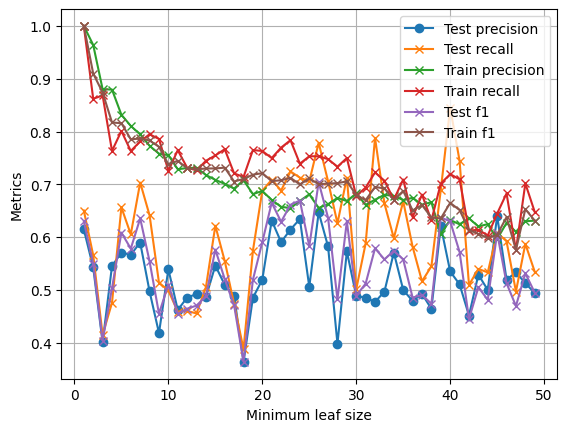

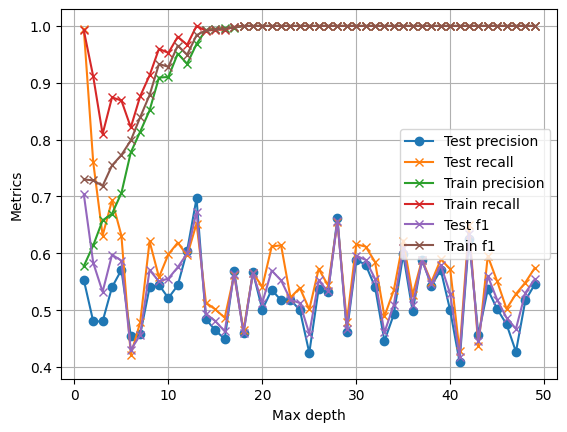

In [144]:
max_val = 50
def avg_decision_tree_classifier(leaf_size, depth, runs=1):
    results = [get_decision_tree_classifier(leaf_size, depth, return_model=False, print_metrics=False) for _ in range(runs)]
    avg_result = tuple(sum(values) / runs for values in zip(*results))
    return avg_result

vals_leaf_size = [avg_decision_tree_classifier(leaf_size, 100) for leaf_size in tqdm(range(1, max_val), leave=True)]
vals_depth = [avg_decision_tree_classifier(1, depth) for depth in tqdm(range(1, max_val))]

def plot_diag(vals, x_label):
    y1_vals, y2_vals, y3_vals, y4_vals, y5_vals, y6_vals = zip(*vals)

    plt.plot(range(1, max_val), y1_vals, label='Test precision', marker='o')
    plt.plot(range(1, max_val), y2_vals, label='Test recall', marker='x')
    plt.plot(range(1, max_val), y3_vals, label='Train precision', marker='x')
    plt.plot(range(1, max_val), y4_vals, label='Train recall', marker='x')
    plt.plot(range(1, max_val), y5_vals, label='Test f1', marker='x')
    plt.plot(range(1, max_val), y6_vals, label='Train f1', marker='x')
    plt.xlabel(x_label)
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_diag(vals_leaf_size, 'Minimum leaf size')
plot_diag(vals_depth, 'Max depth')

In [145]:
leaf_sizes = range(1, max_val)
depths = range(1, max_val)

# Collect results for all combinations of leaf_size and depth
results = np.zeros((len(leaf_sizes), len(depths), 6))  # Assuming 6 metrics

for i, leaf_size in enumerate(tqdm(leaf_sizes, desc="Leaf Sizes")):
    for j, depth in enumerate(depths):
        results[i, j] = avg_decision_tree_classifier(leaf_size, depth)

Leaf Sizes:   0%|          | 0/49 [00:00<?, ?it/s]

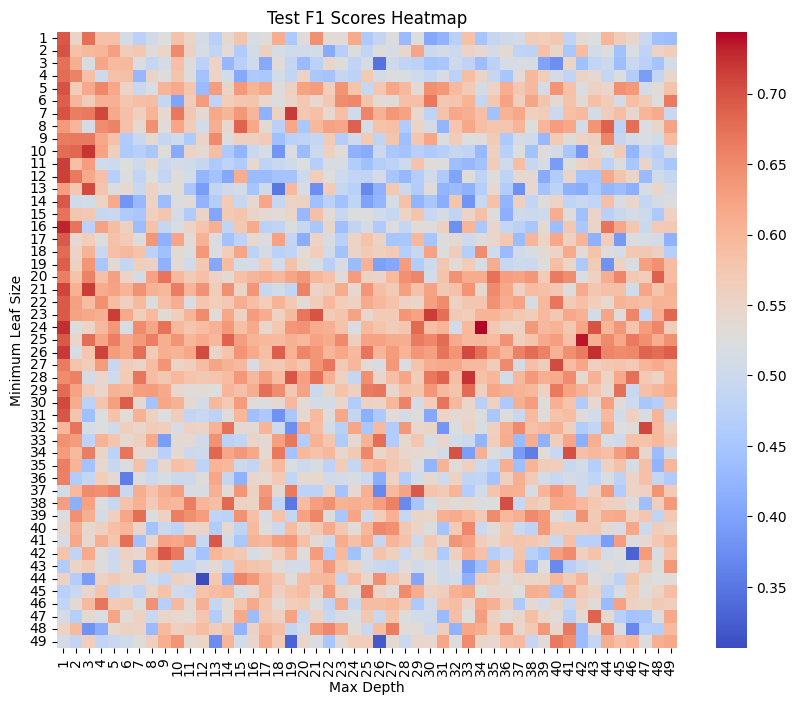

In [146]:
import seaborn as sns

# Extract the Test F1 score (index 4)
test_f1_scores = results[:, :, 4]

plt.figure(figsize=(10, 8))
sns.heatmap(test_f1_scores, xticklabels=depths, yticklabels=leaf_sizes, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Test F1 Scores Heatmap")
plt.xlabel("Max Depth")
plt.ylabel("Minimum Leaf Size")
plt.show()


---

Hyperparameter are min_leaf_size = 40 and max_depth = 5

In [160]:
# clf = DecisionTreeClassifier(min_samples_leaf=25, max_depth=50)

clf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=25)

clf.fit(X, y)

plt.figure(figsize=(40, 20))
# plot_tree(clf, filled=True, feature_names=input_cols, class_names=np.unique(y).astype(str),
#           rounded=True, fontsize=9)
plt.show()

<Figure size 4000x2000 with 0 Axes>

Use the model trained only on student data to predict the holdout student data

In [161]:
X_holdout = df_holdout_students[input_cols]
y_holdout = df_holdout_students[output_col]

y_pred = clf.predict(X_holdout)

precision = precision_score(y_holdout, y_pred)
recall = recall_score(y_holdout, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.4444444444444444
Recall: 0.5128205128205128


In [162]:
X_holdout = df_holdout_non_students[input_cols]
y_holdout = df_holdout_non_students[output_col]

y_pred = clf.predict(df_holdout_non_students[input_cols])

precision = precision_score(y_holdout, y_pred)
recall = recall_score(y_holdout, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.7721518987341772
Recall: 0.5865384615384616
